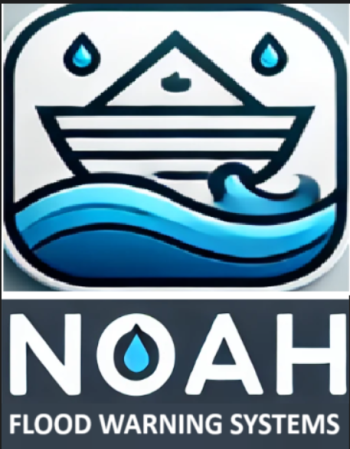

# Noah FWS (Flood Warning Systems)
After the recent natural disaster, the total lack of anticipation from local or national authorities and emergency units that ocurred in Valencia, I realised the need to develop a tool that would alert in time all the population at risk of being affected by a sudden flood that was produced by heavy and constant rains inland. We are talking about registers of 500-800 litres/$m^2$. Here we can see satellite images before and after the floods.

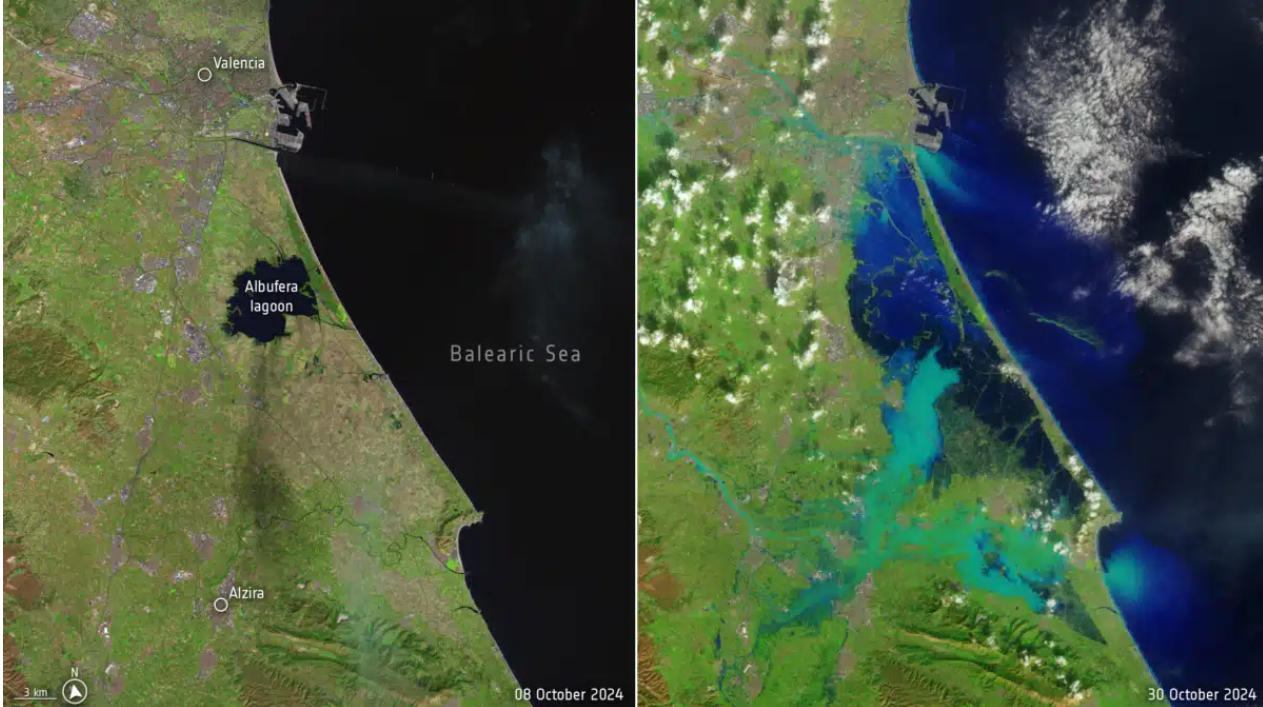

This is a table with measurements from the hidrographic centre of the river Júcar registered during the heavy rains (they registered rains between 500 and 800 l/$m^2$), the metereologist explaining this table on a local tv program could not believe how no one was alarmed at any control or emergency room seeing this numbers. They should have sent an alert to the population inmediately. 2000 $m^3$/s is 5 or 6 times the water flow of Ebro river (one of the biggest in Spain) running through a small stream of water. It is like an inverted tsunami, going from inland to the sea.

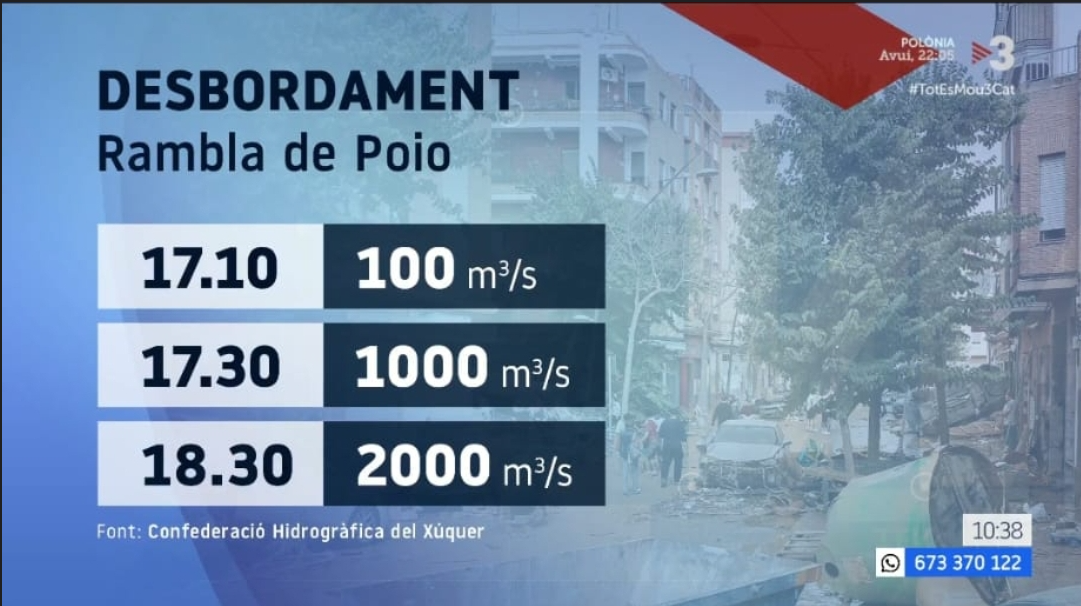

This is a graph I found from the same hidrographic centre (https://saih.chj.es/chj/saih/glayer?t=p) where you can appreciate the sudden growth in water flow from another station located in the river Túria, which used to go through the city of Valencia but they decided to deviate the river outside the city due to another big flood that took place in 1957.

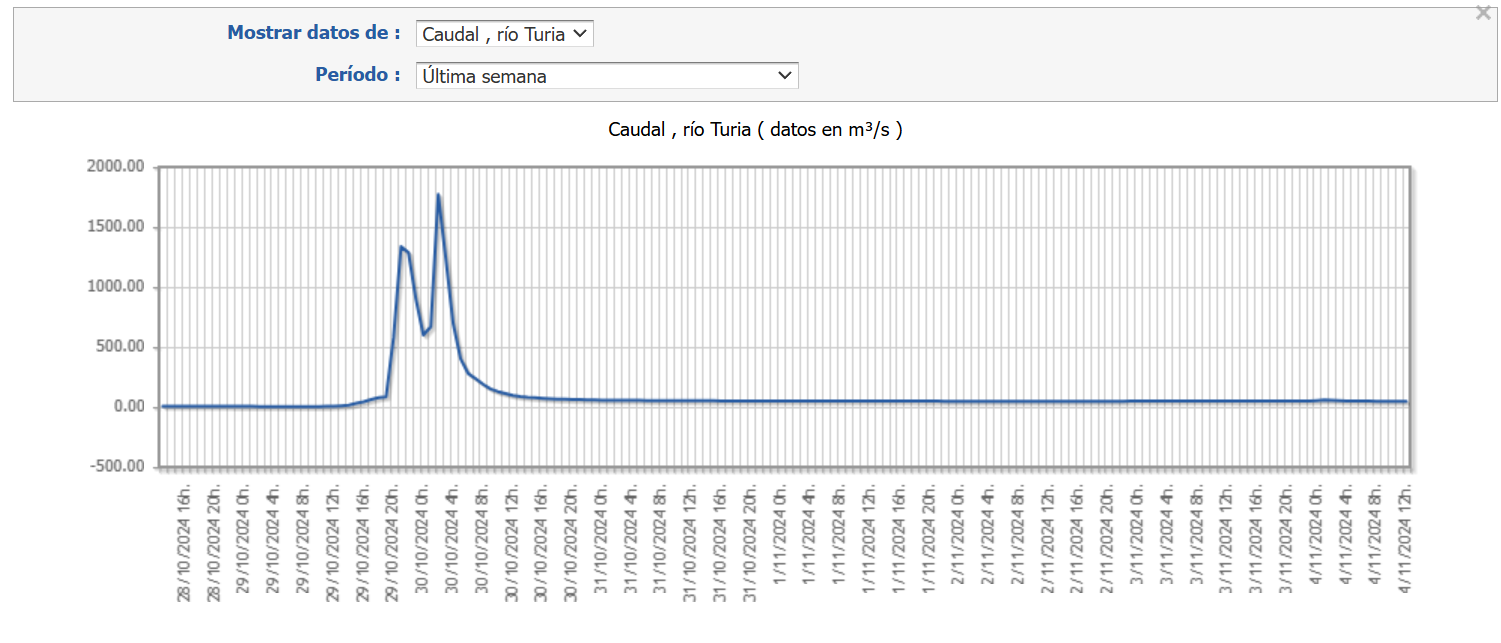

Take into account the population located in risk areas of being affected by the floods was alerted at 8 pm, way to late, causing the death of more than 200 people.

Keeping up with the news, they showed a press notification from the hidrographic centre notifying there is no existence of any alert system on their behalf. They only publish the measurements on their website and it is the emergency units or civil defense's responsibility to act according to the published data.

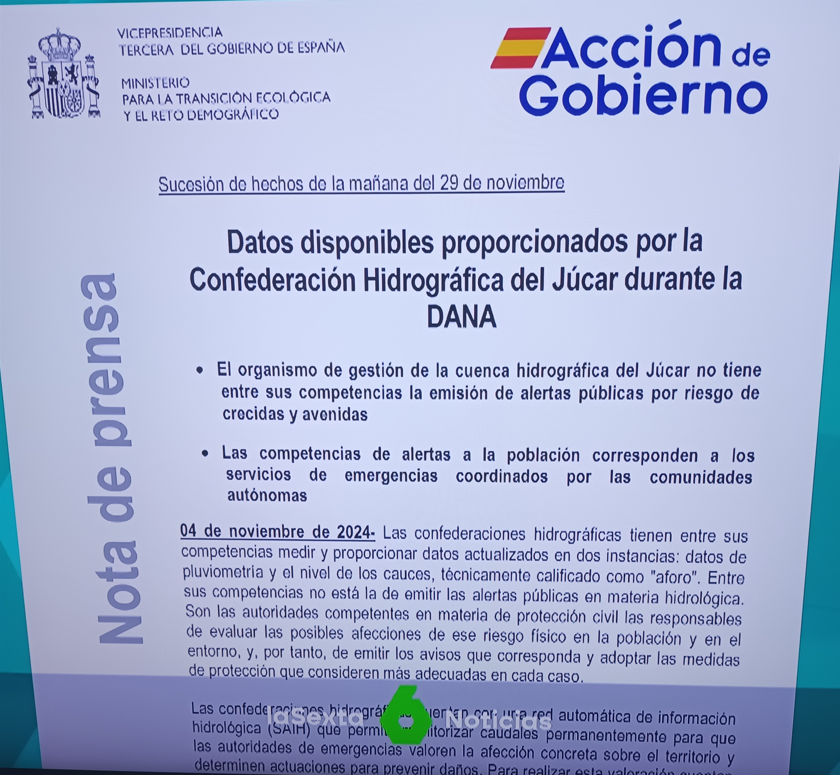

For all these reasons, I thought why not try and develop an automated flood warning system that monitors these live water flow measurements and sends an alert to all towns in any given flood risk area so they can activate not a phone alarm from civil defense, but a siren or a local alarm as cities in the United States do in case a tornado is being formed and about to hit any given area. Local authorities have to make sure people are scared enough by the sound and know they have to look for the nearest building and be high enough to avoid being dragged or even worse, drowned, by the sudden floods. If they live in homes at surface or road height near rivers or water streams, leave inmediately because the water will cover the entire place.

In this notebook, we will develop a flood warning system using Python. The app will use real-time water flow data from rivers and streams to detect flood risks and send alerts if thresholds are exceeded. There was an excessive delay between the events and the phone alert people received. It was already too late

### Main Objectives:
1. Collect water flow data.
2. Monitor water levels and trigger warnings based on thresholds.
3. Integrate basic geolocation data to identify flood-prone areas.
4. Generate alerts for authorities and residents in affected areas.

**Note**: This notebook provides a foundational approach and is adaptable to specific datasets and APIs.

---

We will use the water flow measurements station located in one of the dry riverbeds that got completely overflowed and produced the worst material and human damages during the floodings in Valencia, Rambla del Poyo. Take into account this stream is most of time completely empty. As you could see on the previous table that appeared on a local tv program, the water flow went from 0 to 2000 $m^3$/s in 1 hour and a half.


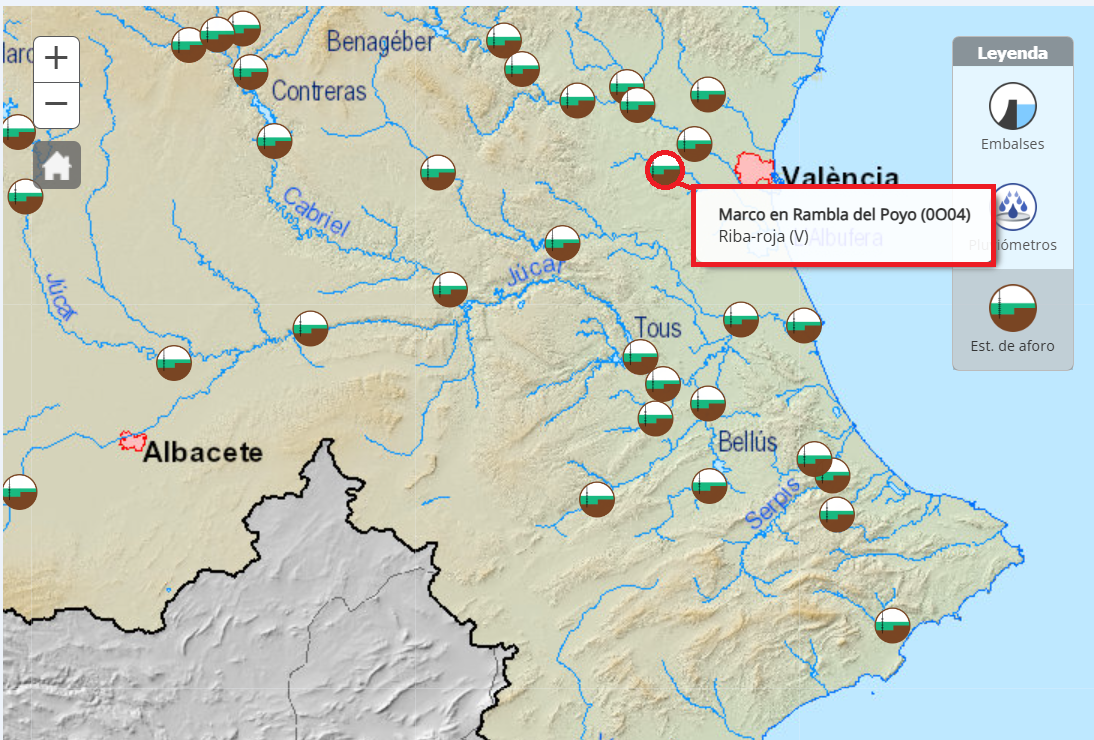

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Set max level threshold in m³/s and name of the station that you want to monitor.
max_level = 2000
station = "Rambla del Poyo"

# Email configuration for alerts
recipient = "miquelsalasg@gmail.com"  # Replace with actual recipient email
subject = "Flow Alert: Critical Level in the Turia River"
smtp_server = "smtp-mail.outlook.com"
smtp_port = 587
sender = "mail sender"  # Replace with actual sender email
password = "password sender"  # Replace with actual password

# Function to send an alert email
def send_alert(flow_rate):
    message_body = (
        f"Alert: {station} has reached a critical level of {flow_rate} m³/s. \nPlease take precautions."
    )
    try:
        msg = MIMEMultipart()
        msg["From"] = sender
        msg["To"] = recipient
        msg["Subject"] = subject
        msg.attach(MIMEText(message_body, "plain"))
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()
            server.login(sender, password)
            server.sendmail(sender, recipient, msg.as_string())
        print(f"Alert sent to {recipient}.")
    except Exception as e:
        print(f"Error sending alert: {e}")

# Function to scrape data and check against max_level
def check_latest_flow_rate():
    # Setup ChromeDriver with options
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    
    try:
        # Access the page
        driver.get("https://saih.chj.es/chj/saih/glayer?t=p")
        
        # Wait until the dropdown is visible (use a wait condition here)
        wait = WebDriverWait(driver, 15)  # Increase timeout if necessary
        try:
            dropdown = wait.until(EC.presence_of_element_located((By.ID, "choose-estacion")))
            dropdown.click()
            # Use a more general selector to try and find the right station option
            option = wait.until(EC.presence_of_element_located((By.XPATH, f"//option[contains(text(), '{station}')]")))
            option.click()
        except Exception as e:
            print(f"Error locating the dropdown or selecting the station: {e}")
            driver.quit()
            return
        
        # Click search button
        try:
            search_button = wait.until(EC.element_to_be_clickable((By.NAME, "buscar-estacion")))
            search_button.click()
        except Exception as e:
            print(f"Error clicking search button: {e}")
            driver.quit()
            return
        
        # Switch to iframe and click "Tabla"
        time.sleep(2)  # Wait for iframe to load
        try:
            iframe = wait.until(EC.presence_of_element_located((By.ID, "fancybox-frame")))
            driver.switch_to.frame(iframe)
            tabla_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[@href='#tabTabla']")))
            tabla_button.click()
        except Exception as e:
            print(f"Error switching to iframe or clicking Tabla: {e}")
            driver.quit()
            return
        
        # Extract and parse the table
        time.sleep(2)  # Wait for table to render
        try:
            table_html = driver.find_element(By.ID, "statsList").get_attribute("outerHTML")
            soup = BeautifulSoup(table_html, 'html.parser')
        except Exception as e:
            print(f"Error extracting table data: {e}")
            driver.quit()
            return
        
        # Extract data into DataFrame
        try:
            headers = [header.get_text() for header in soup.find_all('th')]
            rows = [[col.get_text(strip=True) for col in row.find_all('td')] for row in soup.find_all('tr')[1:]]
            df = pd.DataFrame(rows, columns=headers)
            # Convert the necessary column to float for comparison
            latest_flow = float(df['Valor medido'].iloc[0].replace(",", "."))  # Replace ',' with '.' if present
        except Exception as e:
            print(f"Error processing table data: {e}")
            driver.quit()
            return
        
        # Compare to max_level and trigger alert if exceeded
        if latest_flow >= max_level:
            send_alert(latest_flow)
            print(f"Alert triggered! Latest flow rate: {latest_flow} m³/s")
        else:
            print(f"Flow rate is within normal limits: {latest_flow} m³/s")
    except Exception as e:
        print(f"Error during scraping and checking: {e}")
    finally:
        driver.quit()

# Run the function to test
check_latest_flow_rate()

Flow rate is within normal limits: 0.0 m³/s
